<h3>Imports</h3>

In [24]:
from PIL import Image
from collections import Counter
import datetime, os
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torchvision import datasets, transforms
from torch.utils.data import Dataset
from torch.utils.data import Dataset, DataLoader, random_split
from torch.utils.tensorboard import SummaryWriter
import torchvision.models as models
import torchvision.transforms as transforms

DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
DataLoader = torch.utils.data.DataLoader

SEED = 1
torch.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

<h3>Set-up classes and mappings</h3>

In [25]:
classes = ["ACK", "BCC", "MEL", "NEV", "SCC", "SEK"]
class_to_idx = {cls_name: idx for idx, cls_name in enumerate(classes)}
idx_to_class = {idx: cls_name for cls_name, idx in class_to_idx.items()}

<h3>Pre-processing: cropping and lowering resolution, per paper.</h3>

In [26]:
def crop_center(img, crop_ratio):
    width, height = img.size
    new_size = int(crop_ratio * min(width, height))
    left = (width - new_size) // 2
    top = (height - new_size) // 2
    right = left + new_size
    bottom = top + new_size
    return img.crop((left, top, right, bottom))


transform = transforms.Compose([
    transforms.Lambda(lambda img: crop_center(img, 0.8)),
    transforms.Resize((224, 224)), # 224x224 is a common choice for RESNET-18, I'm told.. 
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], 
                         [0.229, 0.224, 0.225]),
])

<h3>Dataset Class</h3>

In [27]:
class PAD_UFES_Dataset(Dataset):
    def __init__(self, img_dir, label_dict, transform=None):
        self.img_dir = img_dir
        self.label_dict = label_dict
        self.transform = transform
        self.image_files = [f for f in os.listdir(img_dir) 
                            if f.endswith('.png') and f in label_dict]

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        img_name = self.image_files[idx]
        label_name = self.label_dict[img_name]
        label = class_to_idx[label_name]
        img_path = os.path.join(self.img_dir, img_name)
        image = Image.open(img_path).convert('RGB')
        if self.transform:
            image = self.transform(image)
        return image, label

<h3>Establish Paths</h3>

In [28]:
# log_dir_path = '/Users/vedansh/Desktop/230PRJ/skin-lesion-classifier/runs'
log_dir_path = '/Users/nevingeorge/Desktop/CS230/Project/skin-lesion-classifier/runs'

# data_path = os.path.expanduser('~/Desktop/230PRJ/PAD-UFES-20/')
data_path = os.path.expanduser('~/Desktop/CS230/Project/PAD-UFES-20/')
metadata_path = os.path.join(data_path, 'metadata.csv')
images_path = os.path.join(data_path, 'images')

<h3>Load Labels, Initialize and Split dataset</h3>

In [29]:
metadata = pd.read_csv(metadata_path)

label_dict = dict(zip(metadata['img_id'], metadata['diagnostic']))
label_dict = {f"{key}": value for key, value in label_dict.items()}

dataset = PAD_UFES_Dataset(img_dir=images_path, label_dict=label_dict, transform=transform)

dataset_size = len(dataset)
train_size = int(0.8 * dataset_size)
val_size = int(0.1 * dataset_size)
test_size = dataset_size - train_size - val_size
train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])

# Sanity check
assert train_size + test_size + val_size == dataset_size == 2298

<h3>Get class weights for later: potentially weighted softmax, or re-sampling, etc.</h3>

In [30]:
train_labels = [label for _, label in train_dataset]
label_counts = Counter(train_labels)
total_samples = sum(label_counts.values())
class_weights = [total_samples / label_counts[i] for i in range(len(classes))]
class_weights = torch.FloatTensor(class_weights).to(DEVICE)

<h3>Set-up Data Loaders</h3>

In [31]:
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

<h3>Display some images</h3>

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.0357141..2.622571].


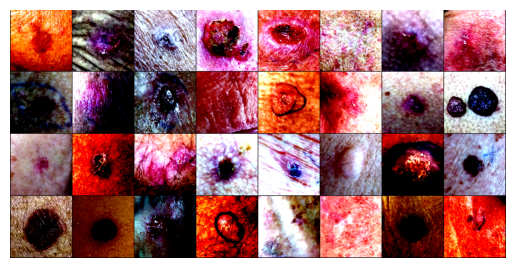

In [32]:
def imshow(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.axis('off')
    plt.show()

images, _ = next(iter(train_loader))
imshow(torchvision.utils.make_grid(images))

<h1>Models</h1>

<h3>RESNET-18</h3>

In [33]:
assert len(classes) == 6

model_resnet18 = models.resnet18(pretrained=True)
num_ftrs = model_resnet18.fc.in_features
model_resnet18.fc = nn.Linear(num_ftrs, len(classes))

# Unfreeze just the last CONV layer and last FC layer, and tweak it for 6 outputs
for param in model_resnet18.parameters():
    param.requires_grad = False
for param in model_resnet18.layer4.parameters():
    param.requires_grad = True
for param in model_resnet18.fc.parameters():
    param.requires_grad = True

model_resnet18 = model_resnet18.to(DEVICE)

/opt/miniconda3/envs/230project/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/miniconda3/envs/230project/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [34]:
criterion_resnet18 = nn.CrossEntropyLoss(weight=class_weights) # Weighted CEL
optimizer_resnet18 = optim.SGD(model_resnet18.parameters(), lr=0.01, momentum=0.9) # Keeping this the same as the paper.
scheduler_resnet18 = optim.lr_scheduler.StepLR(optimizer_resnet18, step_size=7, gamma=0.1) # LR decay.

<h3>RESNET-50</h3>

In [35]:
assert len(classes) == 6

model_resnet50 = models.resnet50(pretrained=True)
num_ftrs = model_resnet50.fc.in_features
model_resnet50.fc = nn.Linear(num_ftrs, len(classes))

# Unfreeze just the last CONV layer and last FC layer, and tweak it for 6 outputs
for param in model_resnet50.parameters():
    param.requires_grad = False
for param in model_resnet50.layer4.parameters():
    param.requires_grad = True
for param in model_resnet50.fc.parameters():
    param.requires_grad = True

model_resnet50 = model_resnet50.to(DEVICE)

/opt/miniconda3/envs/230project/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [36]:
criterion_resnet50 = nn.CrossEntropyLoss(weight=class_weights)
optimizer_resnet50 = optim.SGD(model_resnet50.parameters(), lr=0.01, momentum=0.9)
scheduler_resnet50 = optim.lr_scheduler.StepLR(optimizer_resnet50, step_size=7, gamma=0.1)

<h3>EfficientNet B4</h3>

In [37]:
assert len(classes) == 6

model_efficientnet_b4 = models.efficientnet_b4(pretrained=True)

for param in model_efficientnet_b4.parameters():
    param.requires_grad = False
for param in model_efficientnet_b4.features[-1].parameters():
    param.requires_grad = True
for param in model_efficientnet_b4.classifier.parameters():
    param.requires_grad = True

model_efficientnet_b4 = model_efficientnet_b4.to(DEVICE)

model_efficientnet_b4.classifier = nn.Sequential(
    nn.Dropout(p=0.4, inplace=True),
    nn.Linear(model_efficientnet_b4.classifier[1].in_features, len(classes))
)

/opt/miniconda3/envs/230project/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B4_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B4_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [38]:
criterion_efficientnet_b4 = nn.CrossEntropyLoss(weight=class_weights)
optimizer_efficientnet_b4 = optim.SGD(model_efficientnet_b4.parameters(), lr=0.01, momentum=0.9)
scheduler_efficientnet_b4 = optim.lr_scheduler.StepLR(optimizer_efficientnet_b4, step_size=7, gamma=0.1)

<h3>Custom (Simple) CNN Model</h3>

In [39]:
class SimpleCNN(nn.Module):
    def __init__(self, num_classes):
        super(SimpleCNN, self).__init__()
        # 3 CONV
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        # 1 MAXPOOL
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        # 2 FC
        self.fc1 = nn.Linear(128 * 28 * 28, 256)
        self.fc2 = nn.Linear(256, len(classes))
        # 1 DO
        self.dropout = nn.Dropout(0.5)
    
    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))  # OP Dims: [batch_size, 32, 112, 112]
        x = self.pool(F.relu(self.conv2(x)))  # OP Dims: [batch_size, 64, 56, 56]
        x = self.pool(F.relu(self.conv3(x)))  # OP Dims: [batch_size, 128, 28, 28]
        x = x.view(-1, 128 * 28 * 28)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x

In [40]:
simpleCNN = SimpleCNN(num_classes=len(classes))
assert len(classes) == 6, "incorrect number of classes"
simpleCNN = simpleCNN.to(DEVICE)

criterion_simpleCNN = nn.CrossEntropyLoss(weight=class_weights.to(DEVICE))
optimizer_simpleCNN = optim.Adam(simpleCNN.parameters(), lr=0.001)

<h3>Helper Functions</h3>

In [41]:
def train(model, train_loader, optimizer, criterion, scheduler, num_epochs):
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        running_corrects = 0
        
        for inputs, labels in train_loader:
            inputs = inputs.to(DEVICE)
            labels = labels.to(DEVICE)
            
            optimizer.zero_grad()
            
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            
            loss.backward()
            optimizer.step()
            
            _, preds = torch.max(outputs, 1)
            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)

        if scheduler is not None:
            scheduler.step()
        
        epoch_loss = running_loss / train_size
        epoch_acc = running_corrects.double() / train_size
        
        # Validation
        model.eval()
        val_running_loss = 0.0
        val_running_corrects = 0
        
        with torch.no_grad():
            for val_inputs, val_labels in val_loader:
                val_inputs = val_inputs.to(DEVICE)
                val_labels = val_labels.to(DEVICE)
                
                val_outputs = model(val_inputs)
                val_loss = criterion(val_outputs, val_labels)
                
                _, val_preds = torch.max(val_outputs, 1)
                val_running_loss += val_loss.item() * val_inputs.size(0)
                val_running_corrects += torch.sum(val_preds == val_labels.data)
        
        val_loss = val_running_loss / val_size
        val_acc = val_running_corrects.double() / val_size
        
        print(f'Epoch {epoch+1}/{num_epochs}')
        print(f'Train Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')
        print(f'Val Loss: {val_loss:.4f} Acc: {val_acc:.4f}')

In [42]:
def test(model, test_loader):
    model.eval()
    test_running_corrects = 0
    
    with torch.no_grad():
        for test_inputs, test_labels in test_loader:
            test_inputs = test_inputs.to(DEVICE)
            test_labels = test_labels.to(DEVICE)
            
            test_outputs = model(test_inputs)
            _, test_preds = torch.max(test_outputs, 1)
            test_running_corrects += torch.sum(test_preds == test_labels.data)
    
    test_acc = test_running_corrects.double() / test_size
    print(f'Test Accuracy: {test_acc:.4f}')

<h3>Training Time</h3>

In [29]:
train(model_resnet18, train_loader, optimizer_resnet18, criterion_resnet18, scheduler_resnet18, num_epochs=5)

Epoch 1/5
Train Loss: 1.8268 Acc: 0.3874
Val Loss: 2.0817 Acc: 0.3144
Epoch 2/5
Train Loss: 1.2260 Acc: 0.5838
Val Loss: 1.9983 Acc: 0.2751
Epoch 3/5
Train Loss: 0.5932 Acc: 0.7329
Val Loss: 1.3140 Acc: 0.6157
Epoch 4/5
Train Loss: 0.3224 Acc: 0.8520
Val Loss: 1.6042 Acc: 0.6550
Epoch 5/5
Train Loss: 0.1760 Acc: 0.9102
Val Loss: 1.5719 Acc: 0.7162


In [22]:
train(model_resnet50, train_loader, optimizer_resnet50, criterion_resnet50, scheduler_resnet50, num_epochs=5)

Epoch 1/5
Train Loss: 1.8952 Acc: 0.3411
Val Loss: 2.1162 Acc: 0.5066
Epoch 2/5
Train Loss: 1.2339 Acc: 0.5256
Val Loss: 1.0481 Acc: 0.5109
Epoch 3/5
Train Loss: 0.7807 Acc: 0.6551
Val Loss: 1.0576 Acc: 0.6812
Epoch 4/5
Train Loss: 0.6415 Acc: 0.7274
Val Loss: 1.8011 Acc: 0.6463
Epoch 5/5
Train Loss: 0.3688 Acc: 0.8226
Val Loss: 1.4843 Acc: 0.5764


In [23]:
train(model_efficientnet_b4, train_loader, optimizer_efficientnet_b4, criterion_efficientnet_b4, scheduler_efficientnet_b4, num_epochs=5)

Epoch 1/5
Train Loss: 1.7033 Acc: 0.3079
Val Loss: 1.5739 Acc: 0.4192
Epoch 2/5
Train Loss: 1.4691 Acc: 0.5011
Val Loss: 1.4620 Acc: 0.5109
Epoch 3/5
Train Loss: 1.3471 Acc: 0.5408
Val Loss: 1.3636 Acc: 0.4934
Epoch 4/5
Train Loss: 1.2523 Acc: 0.5158
Val Loss: 1.3109 Acc: 0.5197
Epoch 5/5
Train Loss: 1.1920 Acc: 0.5479
Val Loss: 1.2576 Acc: 0.5502


In [43]:
train(simpleCNN, train_loader, optimizer_simpleCNN, criterion_simpleCNN, None, num_epochs=5)

Epoch 1/5
Train Loss: 1.8637 Acc: 0.3009
Val Loss: 1.4947 Acc: 0.3886
Epoch 2/5
Train Loss: 1.6500 Acc: 0.3069
Val Loss: 1.5464 Acc: 0.3493
Epoch 3/5
Train Loss: 1.6122 Acc: 0.3009
Val Loss: 1.5020 Acc: 0.3624
Epoch 4/5
Train Loss: 1.5752 Acc: 0.3194
Val Loss: 1.4926 Acc: 0.3493
Epoch 5/5
Train Loss: 1.5253 Acc: 0.3368
Val Loss: 1.4678 Acc: 0.3755


<h3>Testing</h3>

In [30]:
test(model_resnet18, test_loader)

Test Accuracy: 0.7273


In [26]:
test(model_resnet50, test_loader)

Test Accuracy: 0.6320


In [27]:
test(model_efficientnet_b4, test_loader)

Test Accuracy: 0.5628


In [44]:
test(simpleCNN, test_loader)

Test Accuracy: 0.3117


<h3>Save Models</h3>

In [ ]:
#saveity save save